In [60]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

if not "../data_processing" in sys.path:
    sys.path.append("../data_processing")
    
if not "../hybrid_analysis_process_functions" in sys.path:
    sys.path.append("../hybrid_analysis_process_functions")

%autoreload
import wt_data
import ff_transform
import explore_fft_time_data
import filters
import resample
import resample_signals


/Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


In [3]:
wt_instance = wt_data.load_instance('WTG04', load_minimal=False)


Loading WTG04...
Loaded WTG04


### Extract Some Vibration Signals

431

In [129]:
signal = 'GbxHssRr;0,0102;m/s2'
vib_signals = []
rot_datas = []
avg_pwrs = []
peak_arrays = []


for i, interval in enumerate(wt_instance.ten_second_intervals):
    vib_signals.append(np.array(interval.sensor_df[signal]))
    rot_datas.append(interval.high_speed_rot_data)
    avg_pwrs.append(interval.op_df["PwrAvg;kW"][0])
    peak_arrays.append(interval.high_speed_peak_array) 
    
    print(f'{i+1} / {len(wt_instance.ten_second_intervals)}', end='\r')

### Plot FFT of Selected Vibration Signals

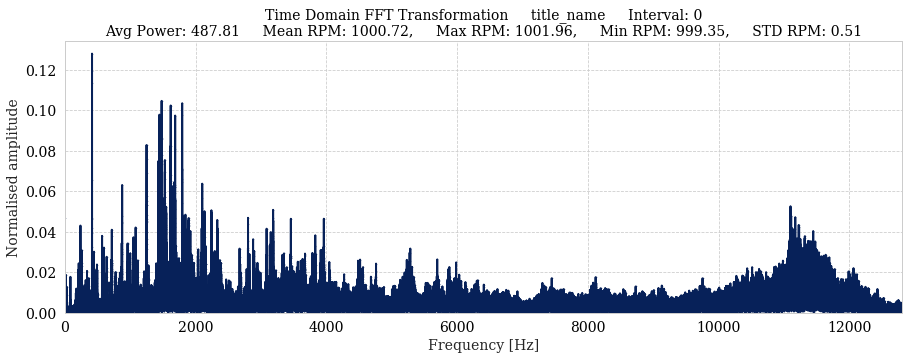

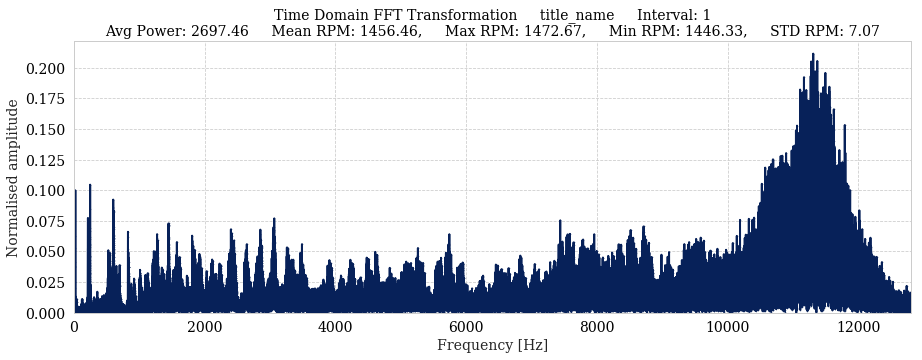

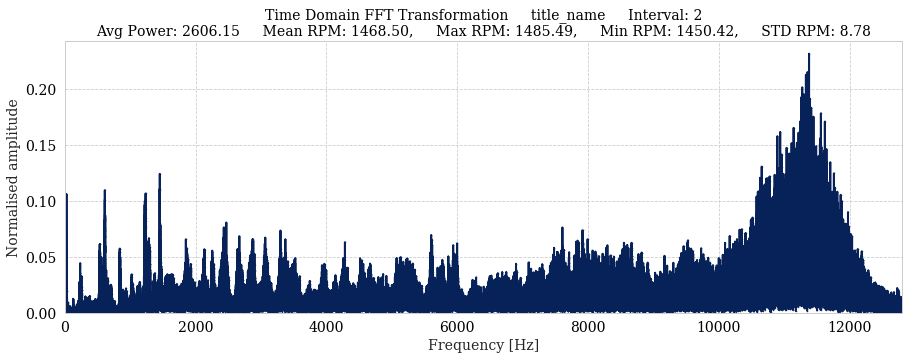

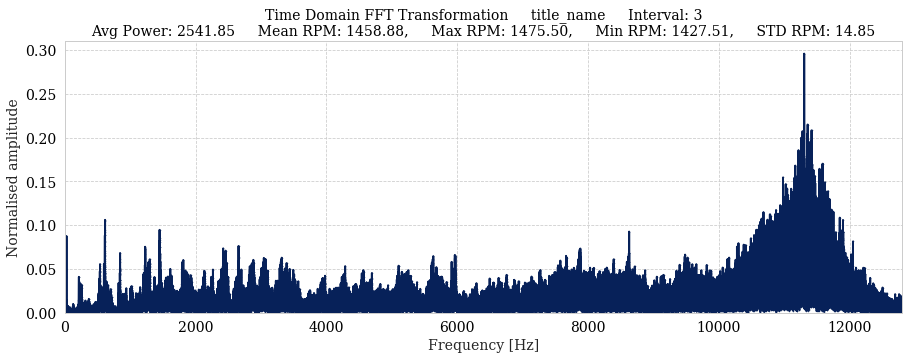

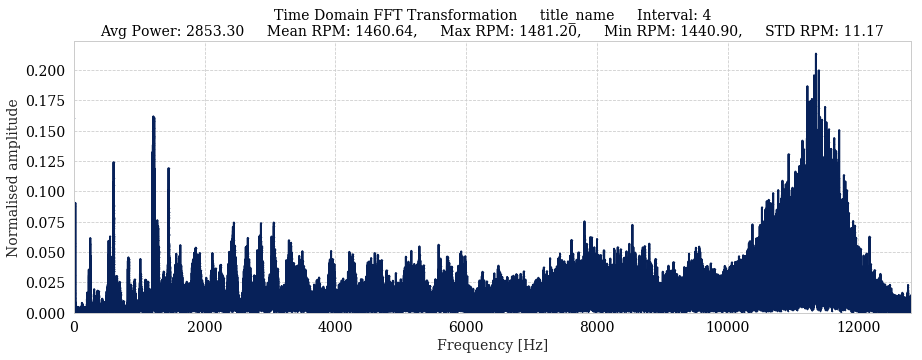

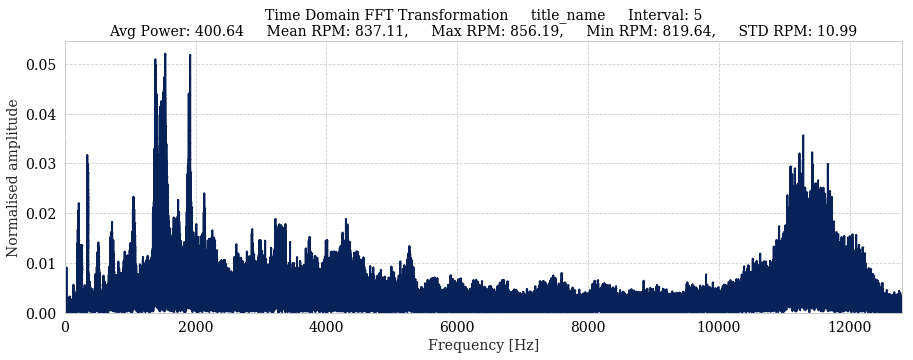

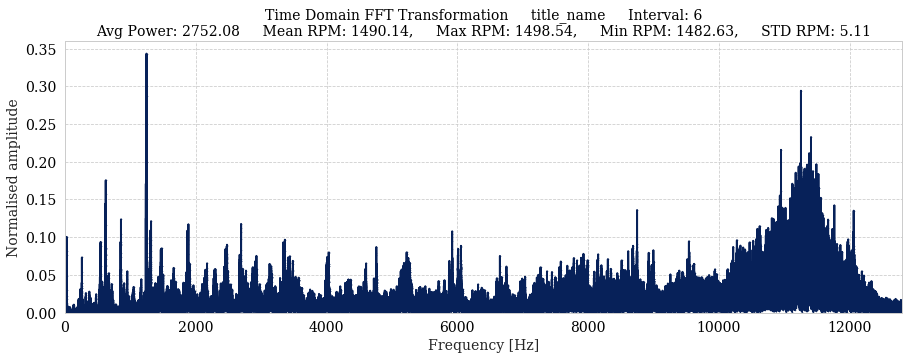

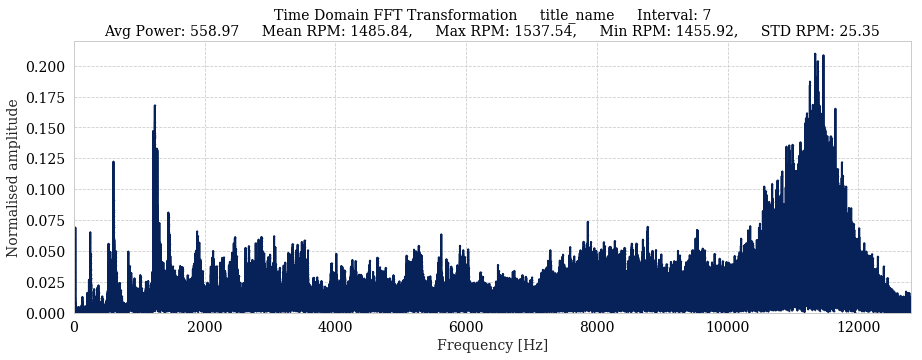

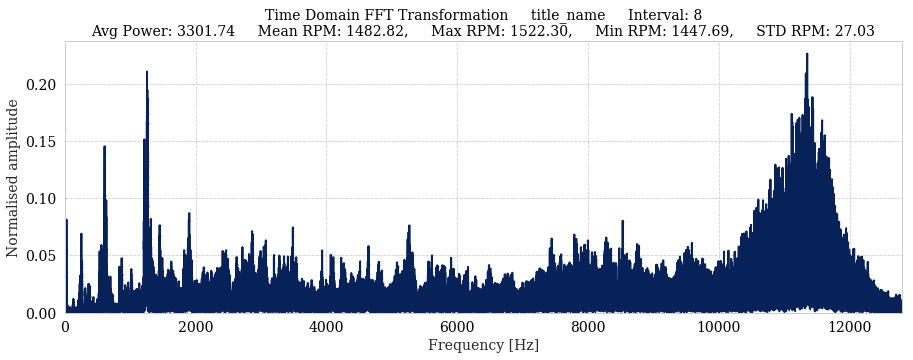

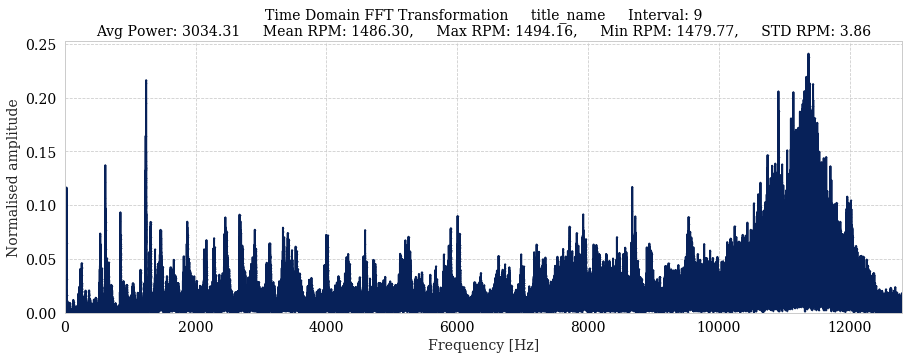

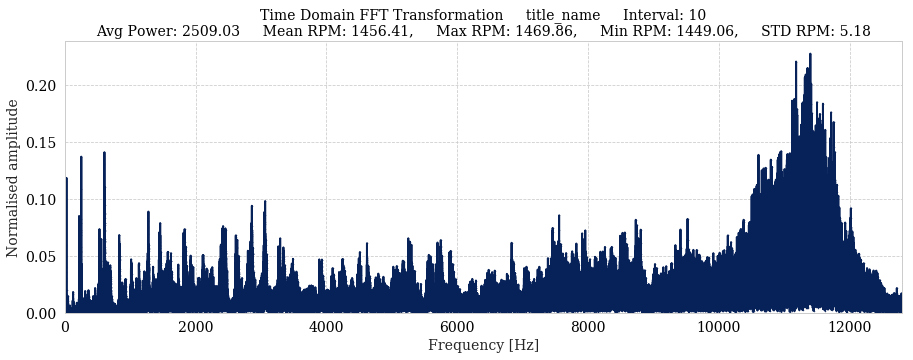

In [136]:
time_stamps = np.asarray(wt_instance.ten_second_intervals[0].sensor_df['TimeStamp'])
for i in range(len(vib_signals)):
    if i>10:
        break
    type = 'gearbox'
    fast = ff_transform.FastFourierTransform(vib_signals[i], time_stamps, type)
    fft, time, centroid, rms, rms_bins, x = fast.fft_transform_time(rot_datas[i],
                                                                    avg_pwrs[i],
                                                                    name='title_name',
                                                                    interval_num=i,
                                                                    plot=True,
                                                                    get_rms_for_bins=False,
                                                                    bins=50,
                                                                    plot_bin_lines=False,
                                                                    )

### Filter Selected Vibration Signals 
Removing the First Frequencies

In [215]:
time_stamps[-1]

10.2399609375

In [171]:
low_cut = 2000
fs = (len(vib_signals[0]))/((time_stamps[-1]))

filtered_vib_signals = []
for vib_sig in vib_signals:
    filtered_vib_sig = filters.butter_hp_filter(vib_sig, low_cut, fs)
    filtered_vib_signals.append(filtered_vib_sig)

### Plot filtered signals

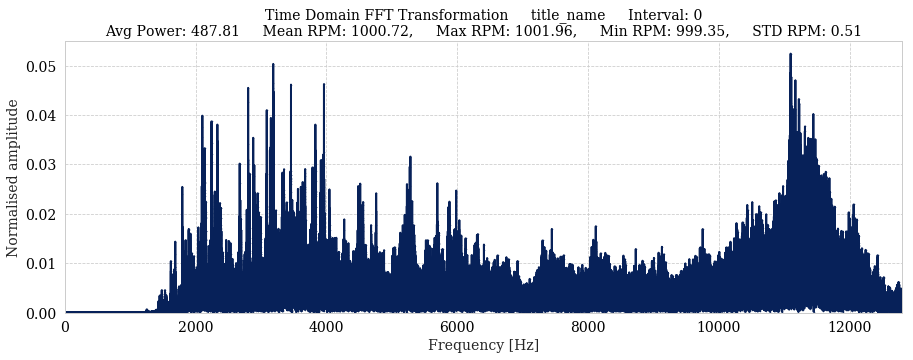

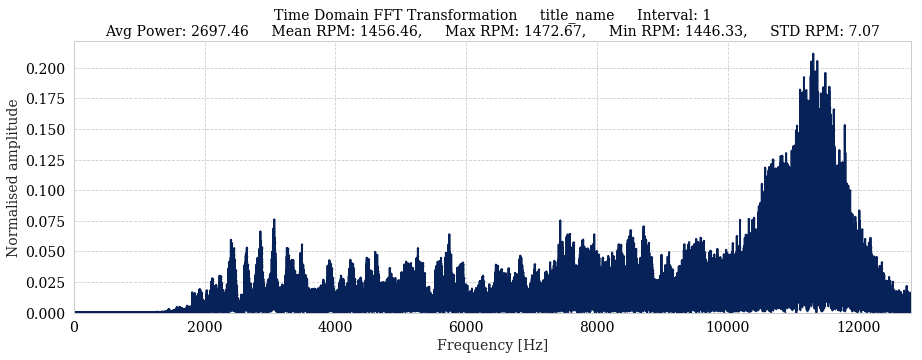

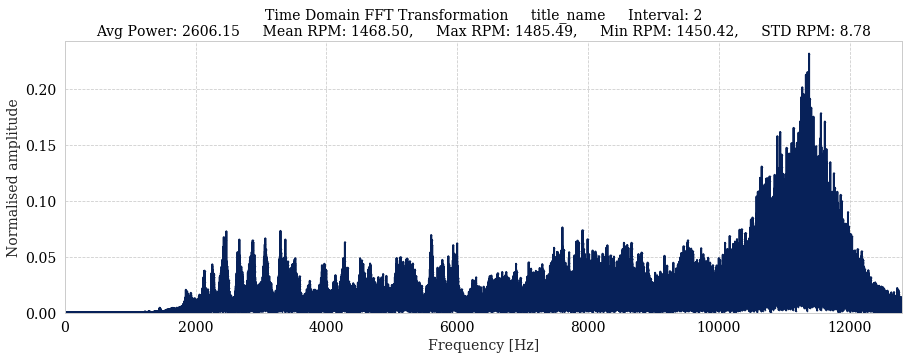

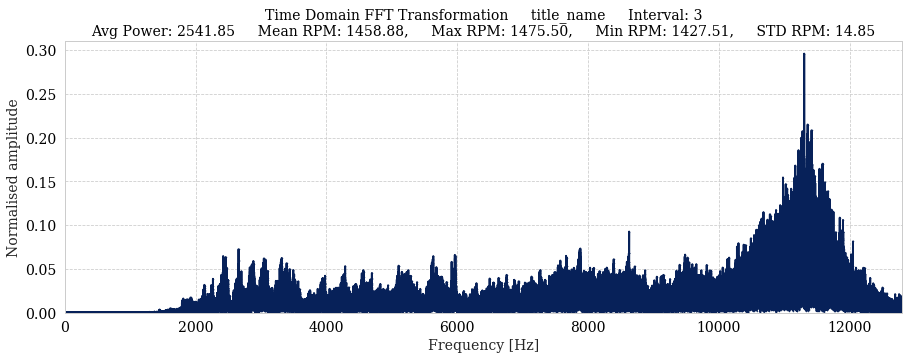

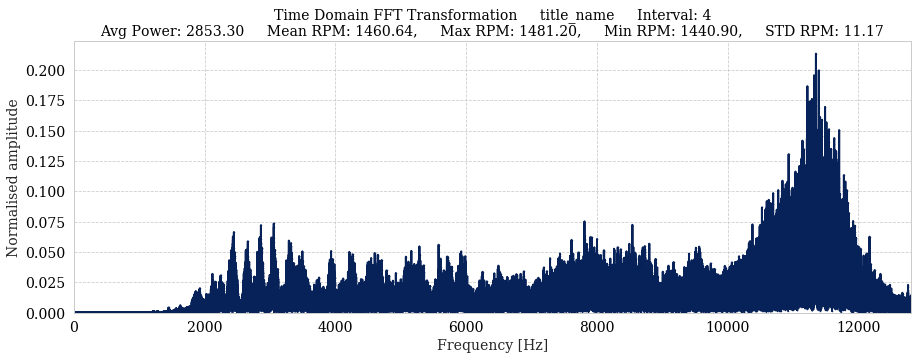

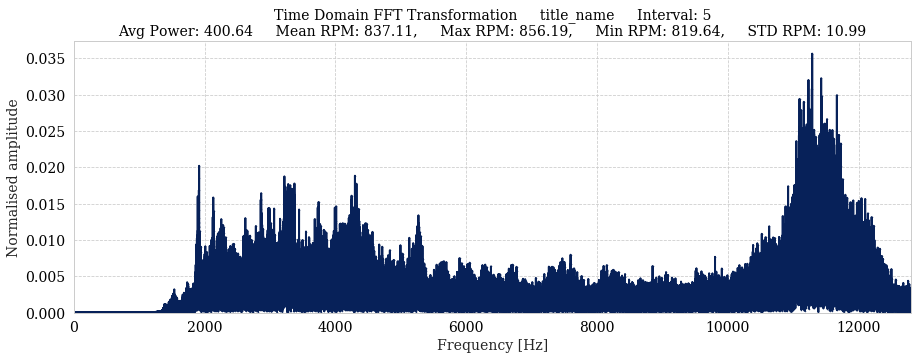

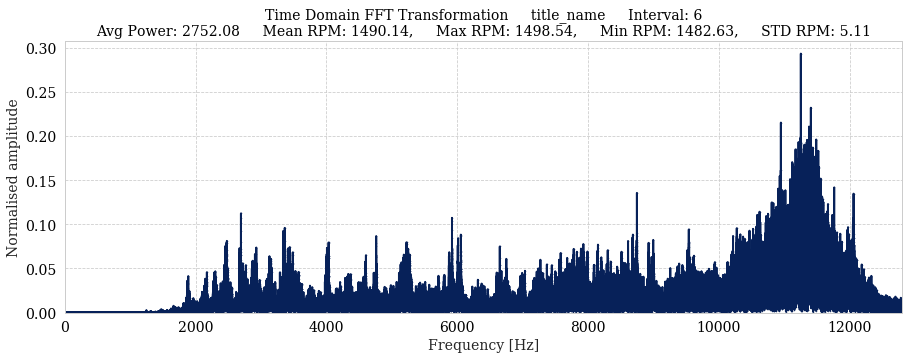

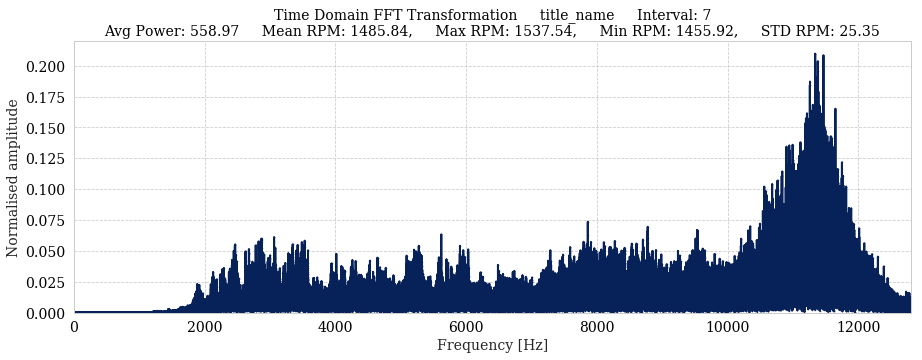

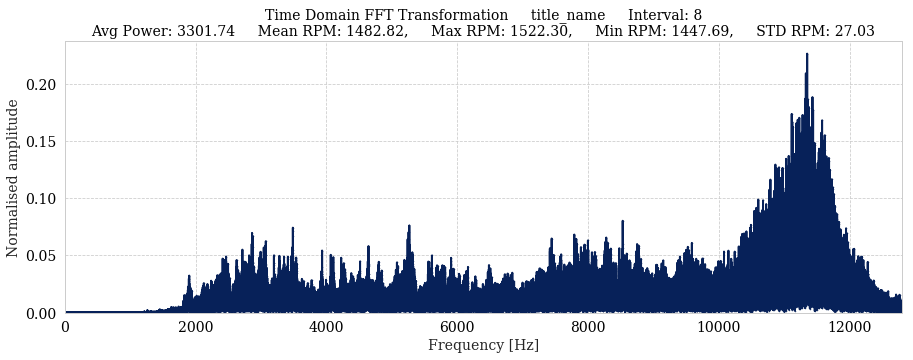

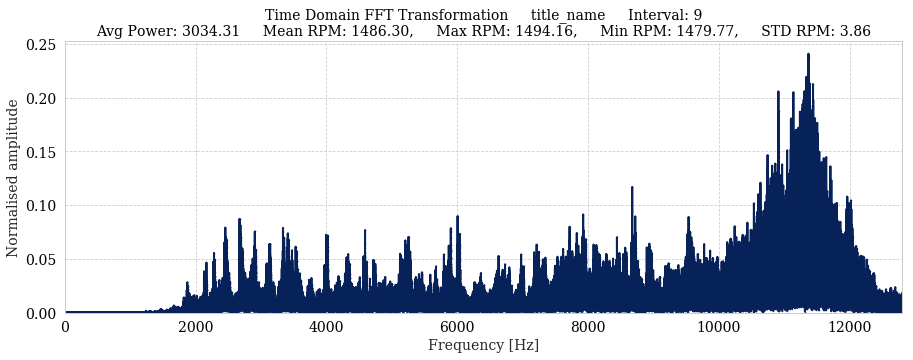

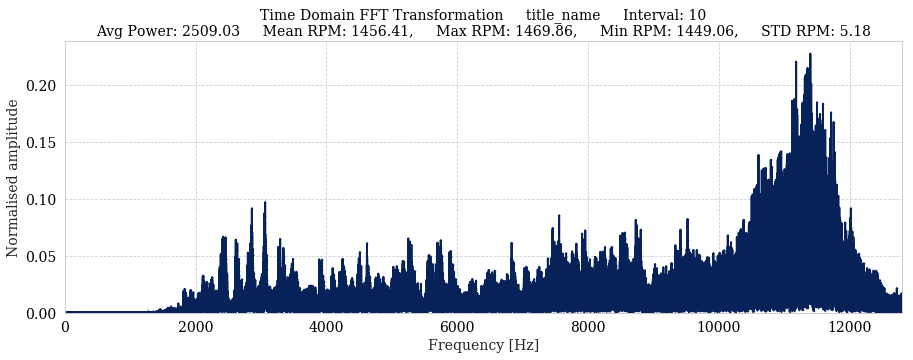

In [172]:
for i in range(len(filtered_vib_signals)):
    if i>10:
        break
    type = 'gearbox'
    fast = ff_transform.FastFourierTransform(filtered_vib_signals[i], time_stamps, type)
    fft, time, centroid, rms, rms_bins, x = fast.fft_transform_time(rot_datas[i],
                                                                    avg_pwrs[i],
                                                                    name='title_name',
                                                                    interval_num=i,
                                                                    plot=True,
                                                                    get_rms_for_bins=False,
                                                                    bins=50,
                                                                    plot_bin_lines=False,
                                                                    )

### Save filtered signals to csv

In [173]:
path = '../../../../../../MATLAB-Drive/Master/'
total_files = len(filtered_vib_signals)
for i, vib_sig in enumerate(filtered_vib_signals):
    np.savetxt(f'{path}vibration_signal_{i}.csv', vib_sig, delimiter=',')
    print(f'Saving {i+1} / {total_files}', end='\r')

### -------- Resampled Signal --------

In [34]:
number_of_resample_points =1500

resampled_vib_signals = []
resampled_time_signals = []
for i, vib_sig in enumerate(vib_signals):
    _, _, x_round, resampled_aplitude, x_time = resample.linear_interpolation_resampling(time_stamps, 
                                                                 vib_sig, 
                                                                 peak_arrays[i], 
                                                                 number_of_resample_points,
                                                                 round_plots=4, 
                                                                 plotting=False,
                                                                 interpolation_method='linear')
    resampled_vib_signals.append(resampled_aplitude)
    resampled_time_signals.append(x_time)

### Plot FFT of Selected Vibration Signals

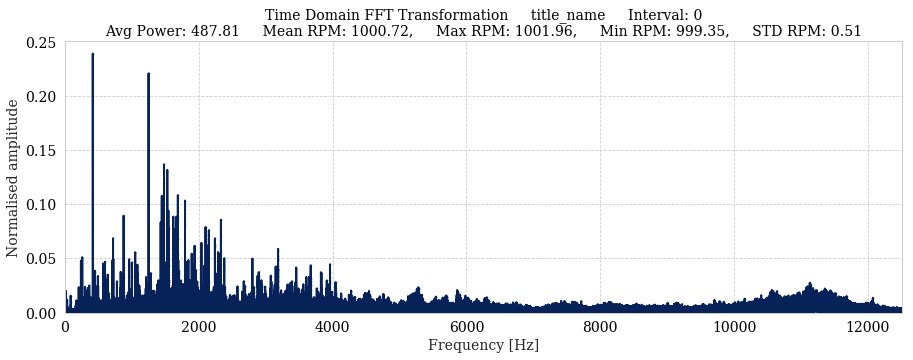

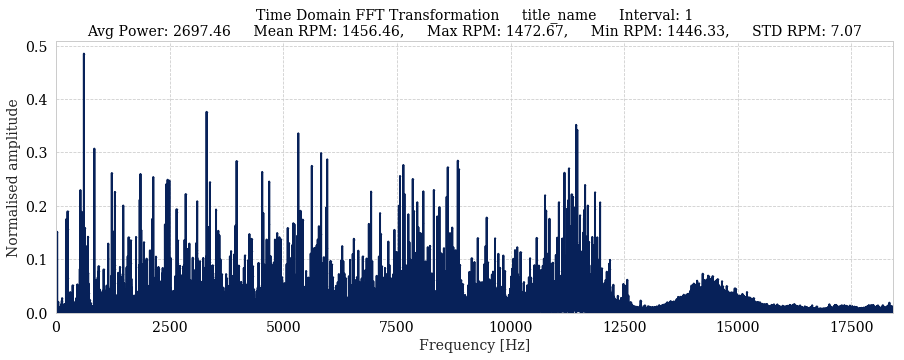

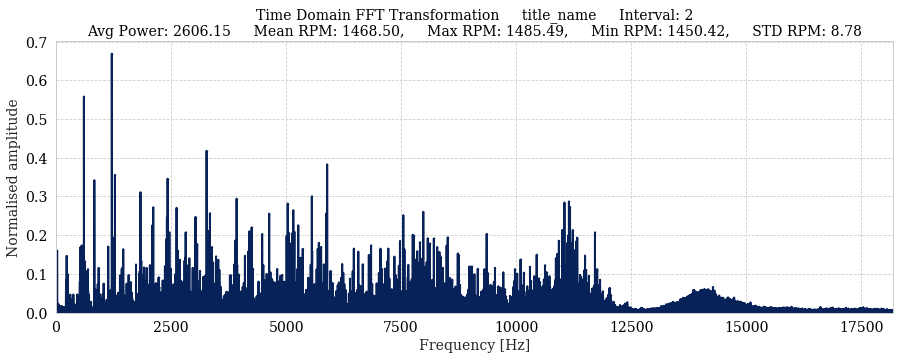

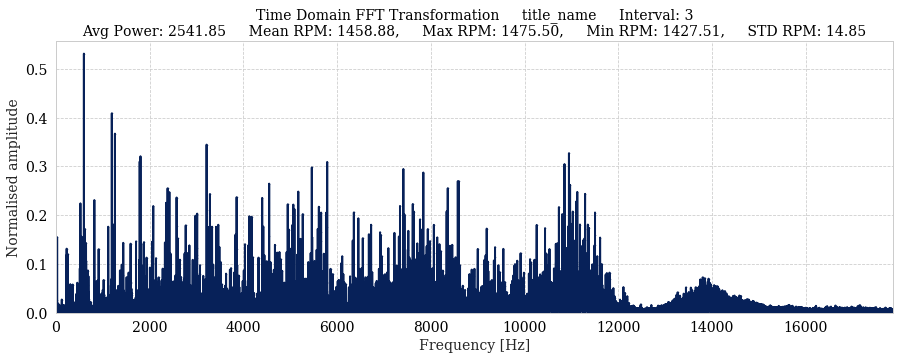

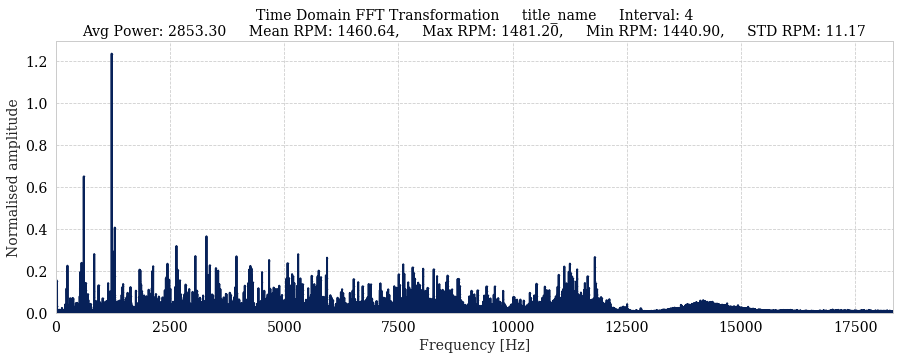

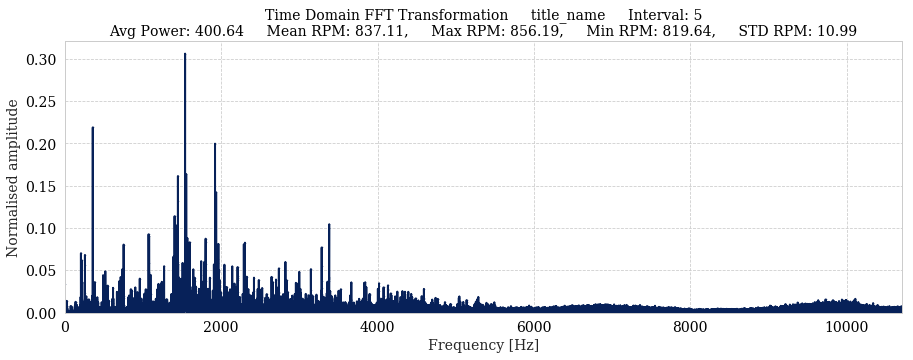

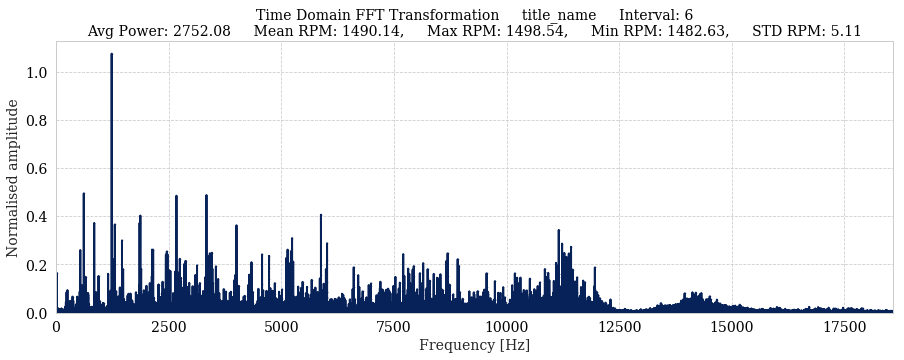

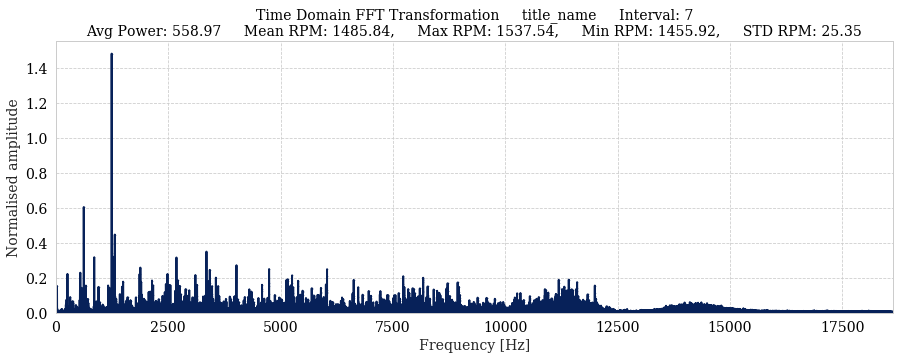

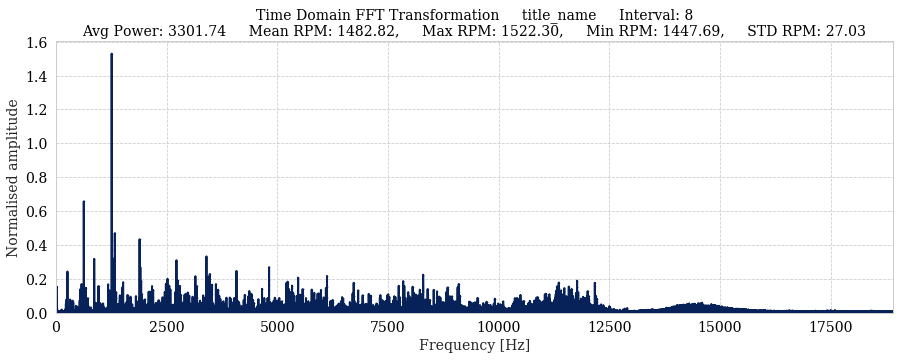

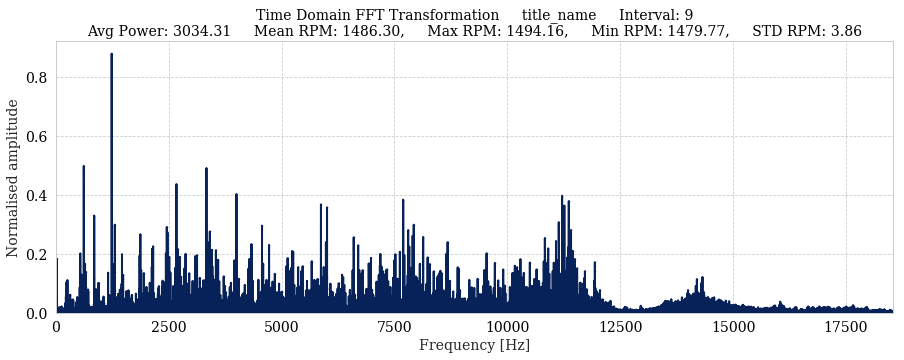

In [35]:
fs_interval = []
for i in range(len(resampled_vib_signals)):
    type = 'gearbox'
    fast = ff_transform.FastFourierTransform(resampled_vib_signals[i], resampled_time_signals[i], type)
    fft, time, centroid, rms, rms_bins, x = fast.fft_transform_time(rot_datas[i],
                                                                    avg_pwrs[i],
                                                                    name='title_name',
                                                                    interval_num=i,
                                                                    plot=True,
                                                                    get_rms_for_bins=False,
                                                                    bins=50,
                                                                    plot_bin_lines=False
                                                                    )
    fs_interval.append(time[-1])

### Filter Selected Vibration Signals 
Removing the First Frequencies

In [102]:
fs

18538.3084445184

In [57]:
filtered_sig_signals = []
for i, res_vib_sig in enumerate(resampled_vib_signals):
    #filtered_sig = filters.butter_hp_filter(res_vib_sig, 2000, fs)
    filtered_sig = filters.butter_hp_filter(res_vib_sig, 2000, fs_interval[i])
    filtered_sig_signals.append(filtered_sig)

### Plot filtered signals

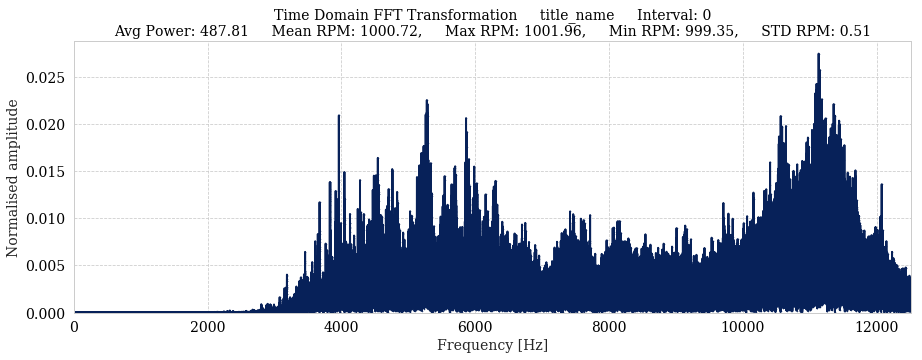

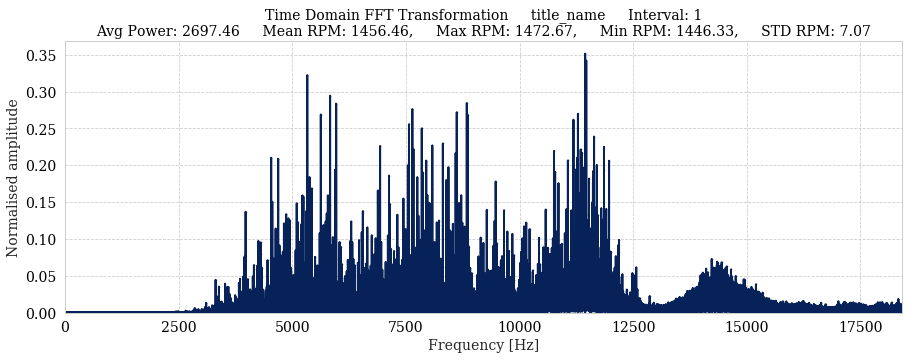

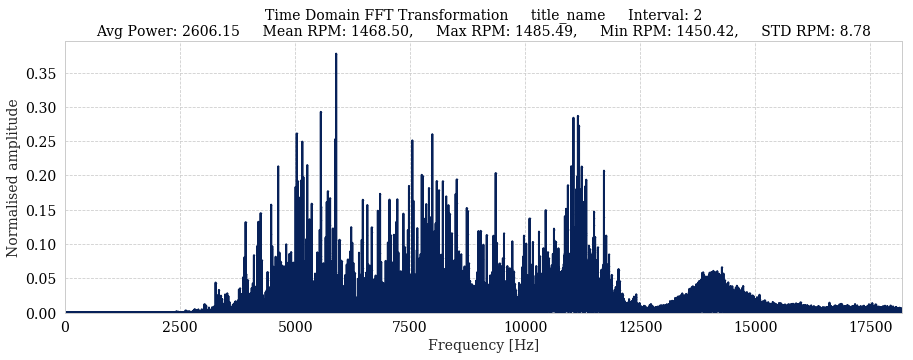

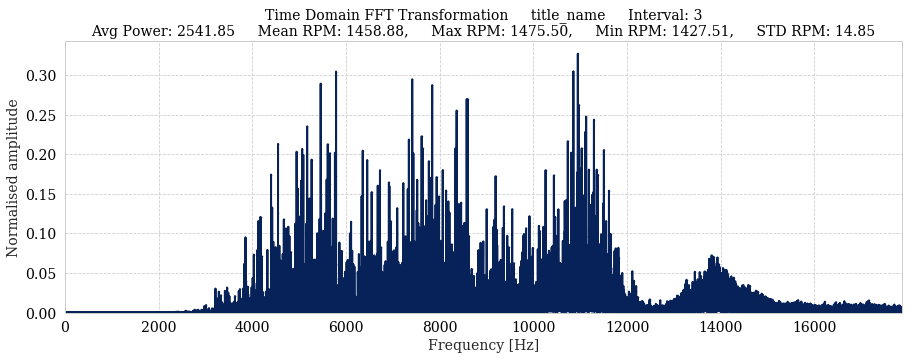

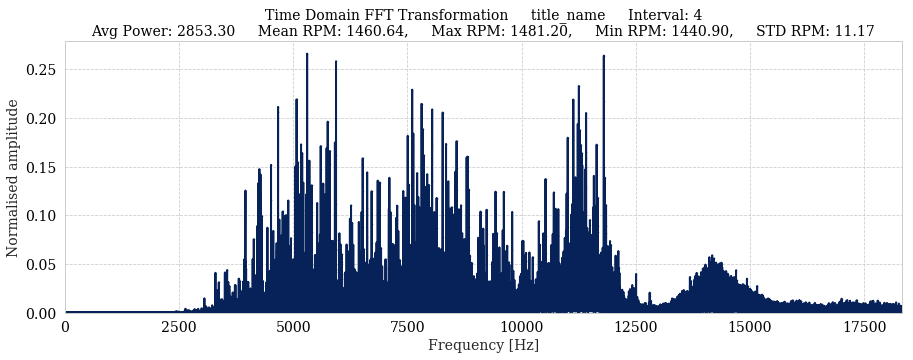

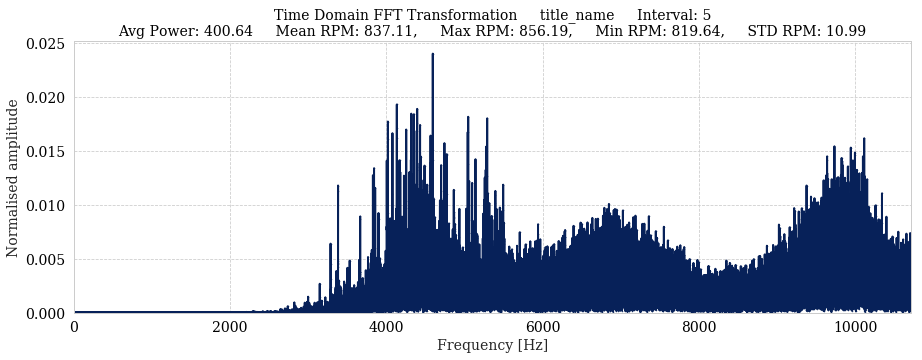

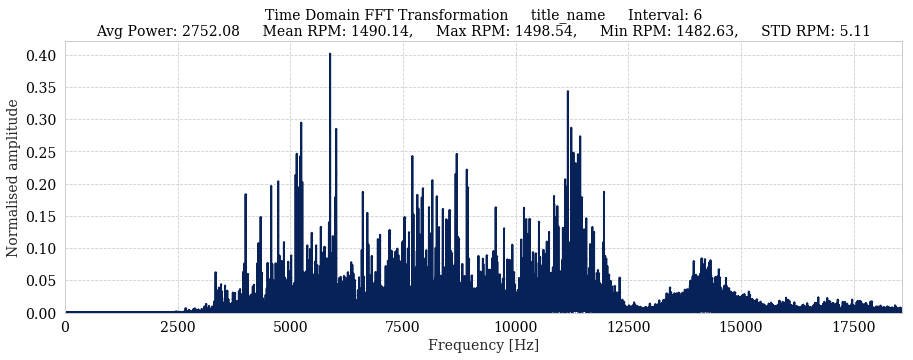

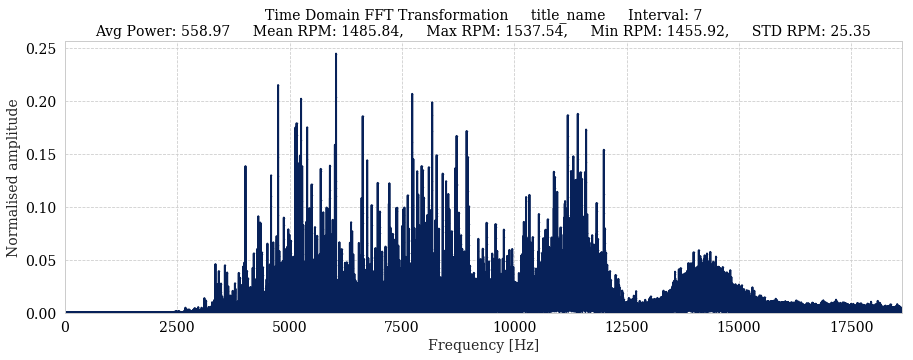

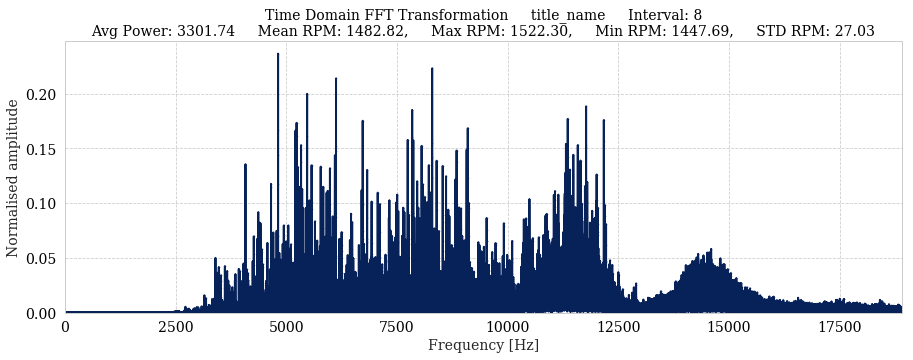

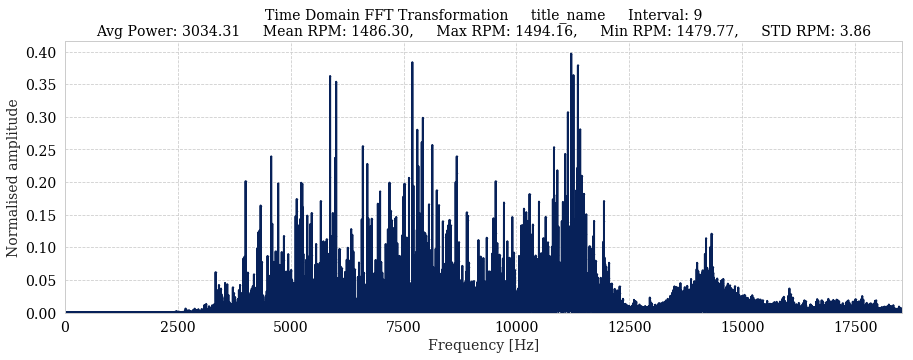

In [58]:
for i in range(len(filtered_sig_signals)):
    type = 'gearbox'
    fast2 = ff_transform.FastFourierTransform(filtered_sig_signals[i], resampled_time_signals[i], type)
    fft, time, centroid, rms, rms_bins, x = fast2.fft_transform_time(rot_datas[i],
                                                                    avg_pwrs[i],
                                                                    name='title_name',
                                                                    interval_num=i,
                                                                    plot=True,
                                                                    get_rms_for_bins=False,
                                                                    bins=50,
                                                                    plot_bin_lines=False)

### Save filtered signals to csv

In [59]:
path = '../../../../../../MATLAB-Drive/Master/'
for i, vib_sig in enumerate(filtered_sig_signals):
    np.savetxt(f'{path}vibration_signal_resampled_{i}.csv', vib_sig, delimiter=',')
    print(f'Saving {i}', end='\r')

In [96]:
filtered_vib_signals_np = np.asarray(filtered_vib_signals).T
np.savetxt(f'{path}test.csv', filtered_vib_signals_np, delimiter=';')

In [95]:
filtered_vib_signals_np = np.asarray(filtered_vib_signals).T
filtered_vib_signals_np.shape

(262144, 10)

In [ ]:
for i, interval in enumerate(wt_instance.ten_second_intervals):
    vib_signals.append(np.array(interval.sensor_df[signal]))
    rot_datas.append(interval.high_speed_rot_data)
    avg_pwrs.append(interval.op_df["PwrAvg;kW"][0])
    peak_arrays.append(interval.high_speed_peak_array) 
    
    print(f'{i+1} / {len(wt_instance.ten_second_intervals)}', end='\r')

In [284]:
%autoreload
import resample_signals
import filter_signals
import fft
import load_raw_signals

ROOT /Users/mortenolsenosvik/Documents/NTNU/Master/master-thesis/src


In [275]:
_, y, x = resample_signals.do_resampling(time_stamps, vib_signals[0], peak_arrays[0])

In [276]:
f = filter_signals.do_high_pass_filter(y, 2000)

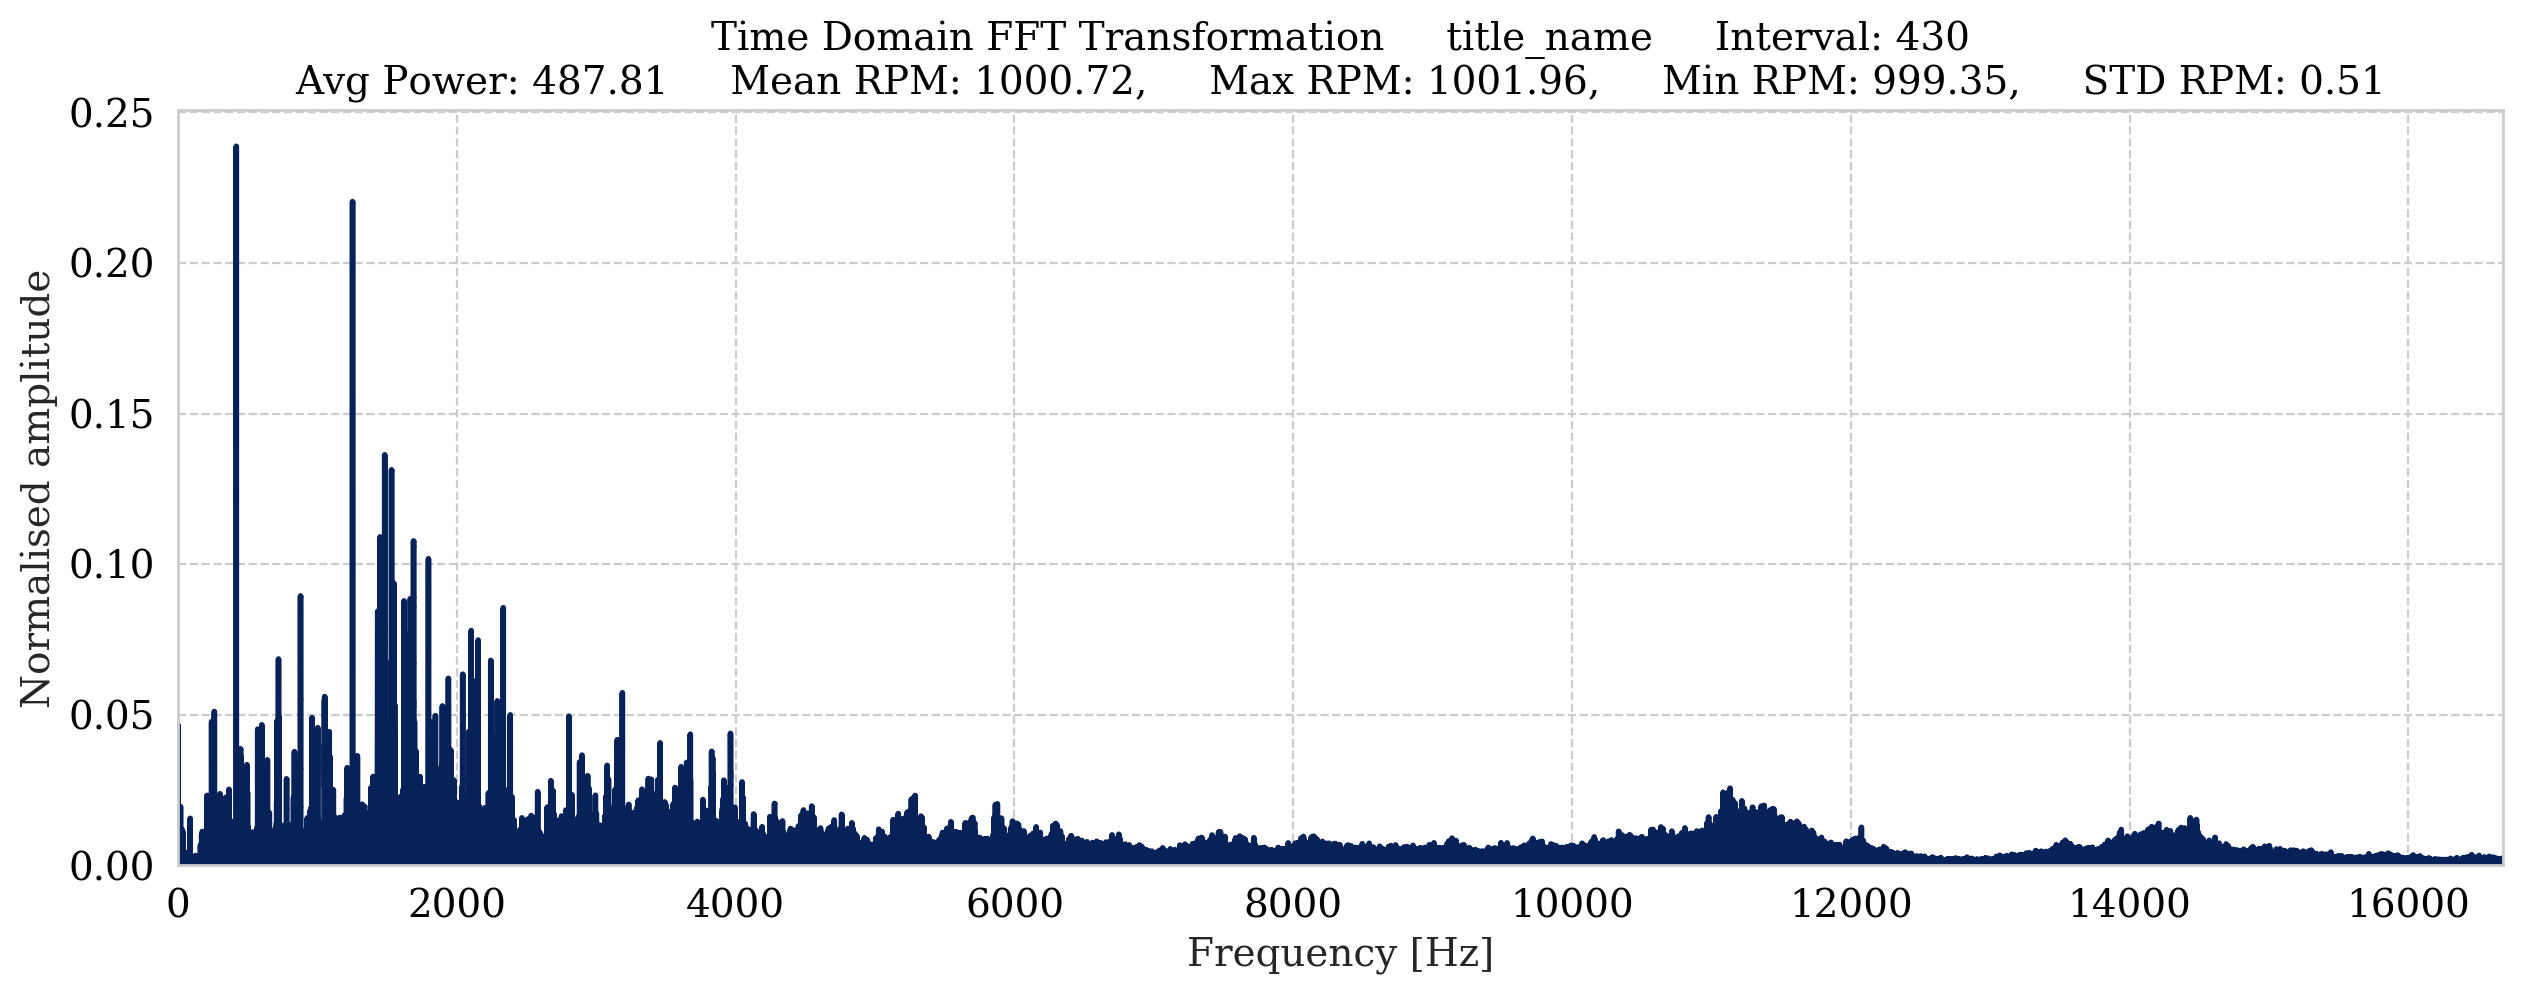

In [280]:
fast = ff_transform.FastFourierTransform(y, x, type)
fft, time, centroid, rms, rms_bins, x = fast.fft_transform_time(rot_datas[0],
                                                                    avg_pwrs[0],
                                                                    name='title_name',
                                                                    interval_num=i,
                                                                    plot=True,
                                                                    get_rms_for_bins=False,
                                                                    bins=50,
                                                                    plot_bin_lines=False)

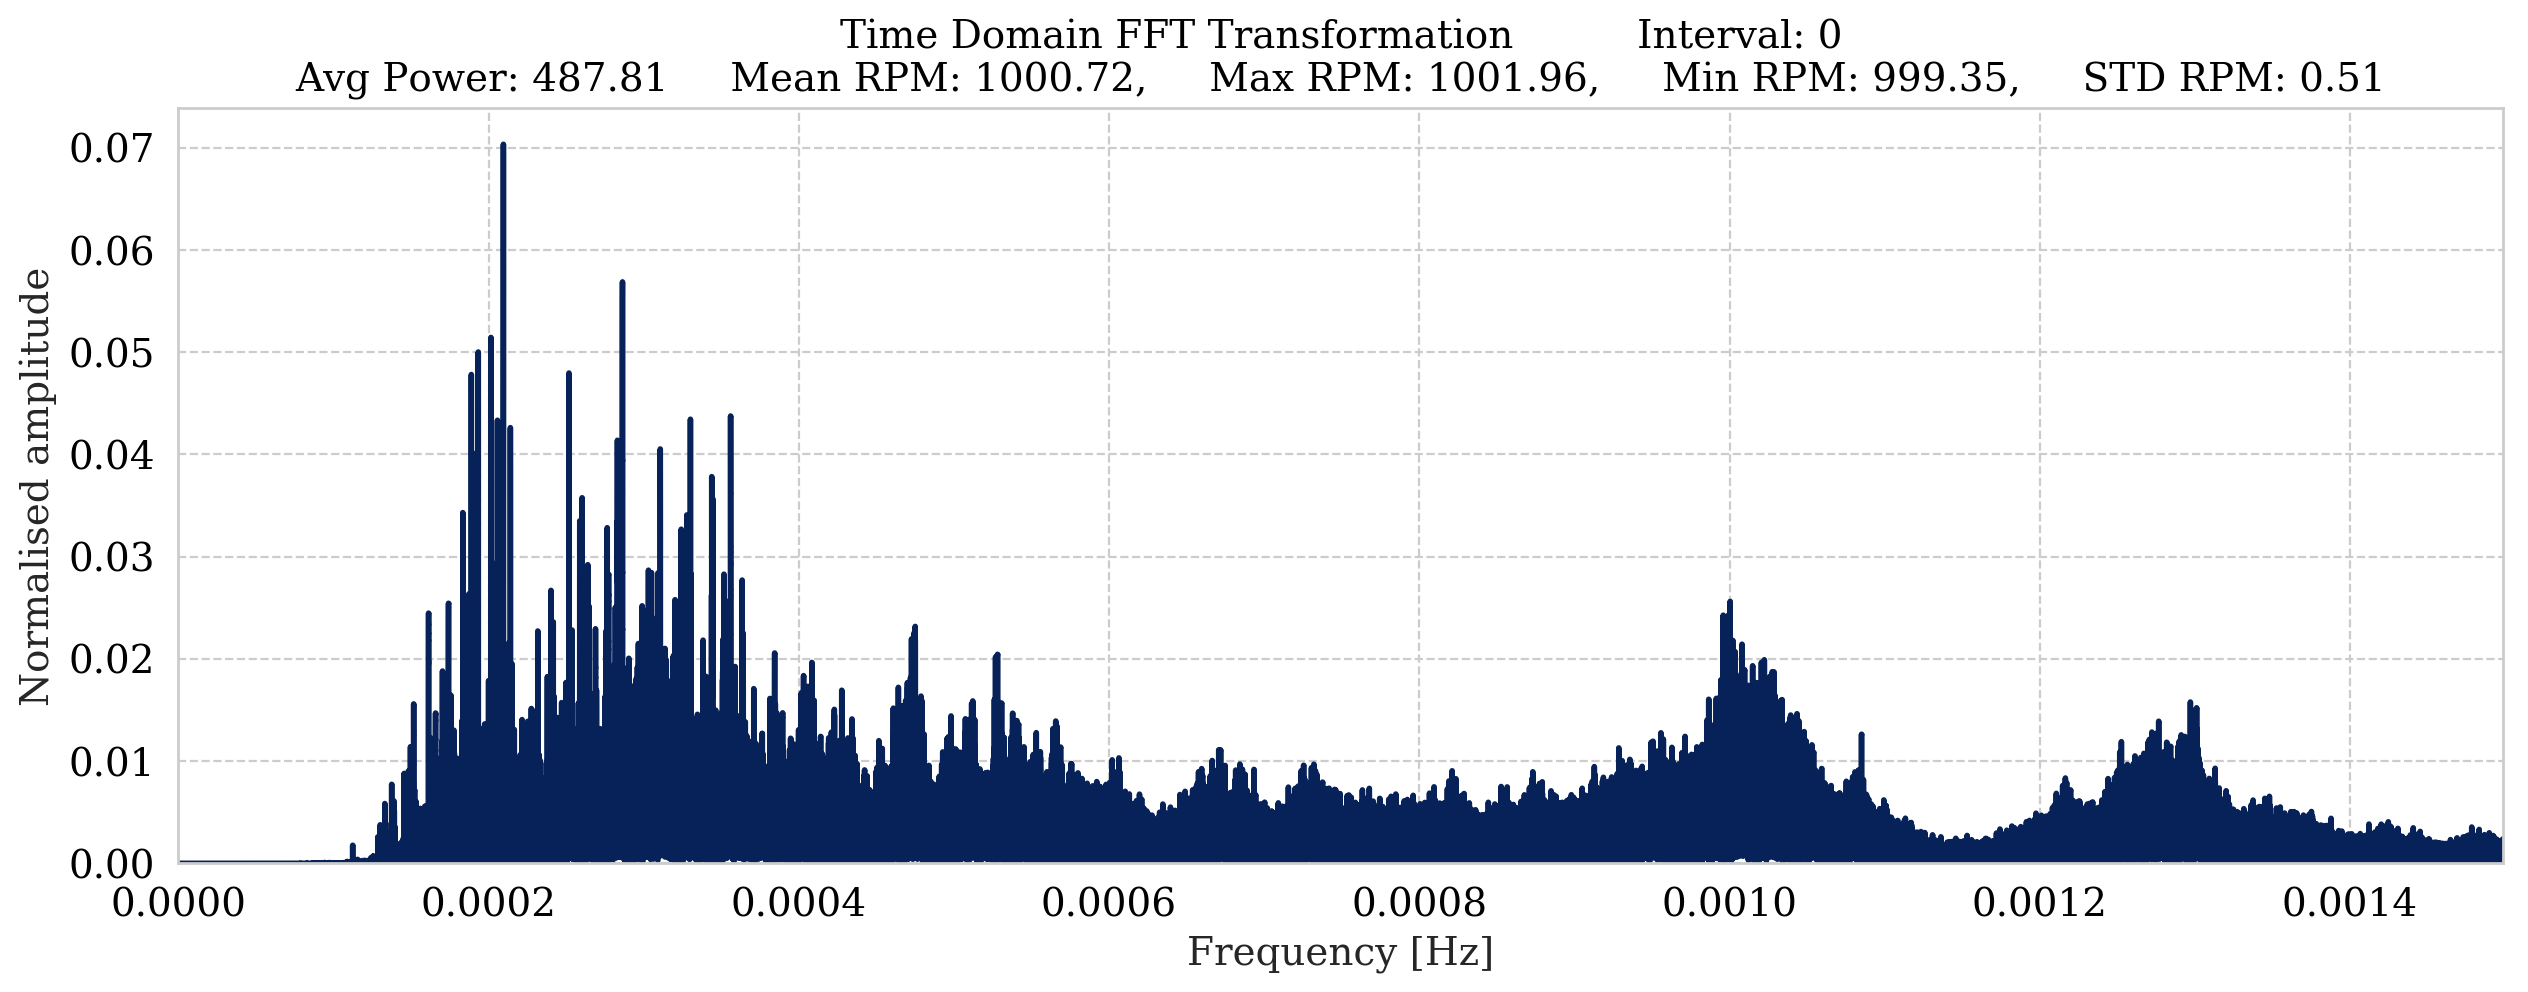

In [283]:
plot = fft.plot_fft(x, f, rot_datas[0],avg_pwrs[0],interval_num=0)

In [287]:
sig, times, intervals_op_data, peak_array = load_raw_signals.load_raw('gearbox', 'wt04')

File exist
